In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import vivarium, vivarium.test_util as vtu
from vivarium.framework.event import listens_for
from vivarium.framework.population import uses_columns
import json
import random

#from reports_header import *
%matplotlib inline
from IPython.display import set_matplotlib_formats
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)
import models.cohort_analysis_function as caf

In [3]:
n_simulants = 5000
n_days = 365
t_start = pd.Timestamp('2017-01-01')
t_timestep = 1
#with open('../data/processed/p_return_by_fac.json') as data_file:    
#    return_rates = json.load(data_file)

In [4]:
fac_return_rates = pd.read_csv('../data/processed/p_return_by_fac.csv', names = ['time', 'facility', 'proba'])
facilities_list = list(fac_return_rates.facility.unique())
fac_return_rates = fac_return_rates.set_index(['time', 'facility'])

In [18]:
fac_return_rates.proba.loc[[(-28.0, 53132.0), (-28.0, 32207.0), (-28.0, 52101.0), (-28.0, 13119.0), (-27.0, 51106.0), (-28.0, 95698.0), (-28.0, 31100.0), (-28.0, 41201.0), (-28.0, 37201.0), (-27.0, 32207.0), (-28.0, 71130.0), (-28.0, 43101.0), (-27.0, 11450.0), (-27.0, 11316.0), (-28.0, 11221.0), (-27.0, 11229.0), (-27.0, 51109.0), (-28.0, 73103.0)]]

time  facility
-28   53132.0     0.037536
      32207.0     0.048292
      52101.0     0.029757
      13119.0     0.034560
-27   51106.0     0.001188
-28   95698.0     0.098039
      31100.0     0.020479
      41201.0     0.039566
      37201.0     0.019694
-27   32207.0     0.007200
-28   71130.0     0.099237
      43101.0     0.008286
-27   11450.0     0.160000
      11316.0     0.005577
-28   11221.0     0.034645
-27   11229.0     0.002451
      51109.0     0.008283
-28   73103.0     0.038689
Name: proba, dtype: float64

## Simulate the cohort

In [19]:
class HIVCohortFollowUp:
    def __init__(self , fac_return_rates):
        self.reports = {}
        self.return_rates = fac_return_rates
        self.current_database = pd.DataFrame({'visit_date':[] , 'next_visit_date':[] , 'facility':[]})
    
    @listens_for('initialize_simulants')
    @uses_columns(['state', 'next_visit_date', 'first_visit','follow_up_duration', 'facility'])
    def initialize(self, event):
        # create the population dataframe
        population = pd.DataFrame(index=event.index)
        population['state'] = 'Out' #TO DO add Dead, transferred, other
        population['next_visit_date'] = pd.NaT
        population['follow_up_duration'] = 0
        population['facility'] = random.choices(facilities_list , k =  n_simulants)
        
        # Give first visit
        first_visit = np.round(np.random.uniform(0, 365, n_simulants))
        population['first_visit'] = t_start + pd.to_timedelta(first_visit, 'D')
        
        # Give first follow up
        rows = np.random.binomial(1, 0.5, size=len(population))
        population['next_visit_date'] = population['first_visit'] + pd.Timedelta(days=7*4)
        
        population.loc[population['first_visit'] == t_start , 'state'] = 'Followed'
        
        # update the population in the model
        event.population_view.update(population)
        
    @listens_for('time_step')
    @uses_columns(['state', 'first_visit', 'next_visit_date', 'facility'], 'state == "Out"')
    def new_patients(self, event):
        df = event.population
        df.loc[df['first_visit'] == event.time, 'state'] = 'Followed'
        df.loc[df['first_visit'] == event.time, 'next_visit_date'] = event.time + pd.Timedelta(days=7*4)
        n_new = len(df.loc[df['first_visit'] == event.time])
        self.current_database = self.current_database.append(pd.DataFrame({'visit_date':[event.time]*n_new, 
                                                                          'next_visit_date':df.loc[df['first_visit'] == event.time, 
                                                                                                   'next_visit_date'],
                                                                          
                                                                          'facility':df.loc[df['first_visit'] == event.time, 
                                                                                                   'facility']} , 
                                                             index = df.index[df['first_visit'] == event.time]))
        
        event.population_view.update(df)
        
    @listens_for('time_step')
    @uses_columns(['state', 'next_visit_date','facility'], 'state != "Out"')
    def next_appointment(self, event):
        df = event.population
        df.visit_delay = (event.time - df['next_visit_date'])/ np.timedelta64(1, 'D')
        
        list_draw = []
        for h in range(len(df)):
            list_draw = list_draw + [(df.visit_delay.iloc[h] , df.facility.iloc[h])]
        visit = np.random.binomial(1, list(self.return_rates.proba.loc[list_draw].fillna(0)), size=len(df))
        visitors = list(df.index[visit == 1])
        n_visitors = len(visitors)
        
        df.loc[visitors, 'next_visit_date'] = event.time + pd.Timedelta(days=7*4)
        if n_visitors > 0 :
            self.current_database = self.current_database.append(
                pd.DataFrame({'visit_date':[event.time]*n_visitors,
                              'next_visit_date': df.loc[visitors, 'next_visit_date'],
                             'facility' : df.loc[visitors, 'facility']} ,
                             index = list(df.loc[visitors].index)))
        
        event.population_view.update(df)
        
    @listens_for('time_step')
    @uses_columns(['state'], 'state != "Out"')
    def export_report_datapoint(self, event):
        date = event.time
        self.reports[date] = event.population.state.value_counts()

In [20]:
components = [HIVCohortFollowUp(fac_return_rates)]
vtu.config.simulation_parameters.time_step = 1/365
simulation = vtu.setup_simulation(components, population_size=n_simulants, start=t_start)
vtu.pump_simulation(simulation, time_step_days=t_timestep, duration=pd.Timedelta(days=n_days))

23
23
35
35
48
48
60
60
69
69
83
83
93
93
109
109
124
124
138
138
151
151
162
162
182
182
193
193
200
200
216
216
225
225
238
238
248
248
263
263
275
275
289
289
301
301
308
308
323
323
337
337
354
354
370
370
382
382
403
403
421
421
441
441
454
454
464
464
477
477
496
496
505
505
519
519
532
532
552
552
565
565
581
581
596
596
606
606
618
618
628
628
641
641
652
652
668
668
681
681
699
699
708
708
720
720
735
735
758
758
767
767
783
783
793
793
807
807
818
818
834
834
848
848
863
863
873
873
880
880
893
893
906
906
924
924
934
934
952
952
963
963
969
969
986
986
1005
1005
1019
1019
1029
1029
1041
1041
1053
1053
1064
1064
1074
1074
1089
1089
1102
1102
1114
1114
1127
1127
1141
1141
1157
1157
1169
1169
1183
1183
1198
1198
1211
1211
1225
1225
1241
1241
1265
1265
1282
1282
1290
1290
1308
1308
1322
1322
1334
1334
1344
1344
1360
1360
1377
1377
1385
1385
1396
1396
1410
1410
1426
1426
1442
1442
1460
1460
1478
1478
1489
1489
1503
1503
1515
1515
1529
1529
1544
1544
1561
1561
1579
1579
1599
1599


365

## Simulate Data Entry

16.0


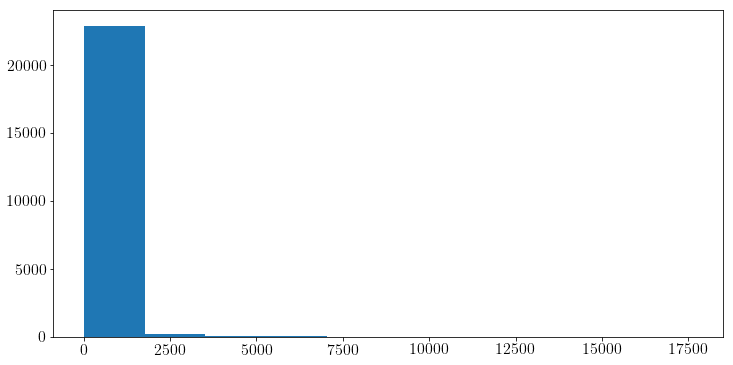

In [21]:
full_database = components[0].current_database.copy()

weibull = np.random.weibull(.4, len(full_database))
times = np.round(weibull*40)
print(np.median(times))
plt.hist(times , bins=10);

In [22]:
full_database

,facility,next_visit_date,visit_date
124,81102.0,2017-01-30,2017-01-02
157,41100.0,2017-01-30,2017-01-02
392,35201.0,2017-01-30,2017-01-02
436,35101.0,2017-01-30,2017-01-02
708,71301.0,2017-01-30,2017-01-02
788,31101.0,2017-01-30,2017-01-02
2799,31102.0,2017-01-30,2017-01-02
2819,32207.0,2017-01-30,2017-01-02
3072,13199.0,2017-01-30,2017-01-02
3149,13120.0,2017-01-30,2017-01-02


In [23]:
def create_data_entry_date(data, delta):
    data['delta'] = pd.to_timedelta(delta , 'days')
    data['date_entered'] = data.visit_date + data.delta
    data['patient_id']= full_database.index
    data = data.reset_index()
    data = data.groupby(['facility','patient_id']).apply(caf.get_first_visit_date)
    return data

In [24]:
data1 = create_data_entry_date(full_database, 0)
data2 = create_data_entry_date(full_database , times)

In [25]:
data1['reasonDescEn'] = np.nan
data2['reasonDescEn'] = np.nan
data1['discDate'] = pd.NaT
data2['discDate'] = pd.NaT

In [26]:
months_of_interest = ['2017-02-01', '2017-03-01', '2017-04-01', '2017-05-01', 
                      '2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01', 
                      '2017-10-01', '2017-11-01', '2017-12-01', '2018-01-01']

In [27]:
def make_report_trail(data, months_of_interest):
    months_reports = {}
    for month in months_of_interest:
        out = data.groupby(data.patient_id).apply(caf.status_patient, reference_date = month,
                                                analysis_date = month, grace_period = 90)
        if len(out) > 0 :
            months_reports[month] = out.status.value_counts()
    return pd.DataFrame.from_dict(months_reports, orient='index')

In [28]:
report_1 = data1.groupby('facility').apply(make_report_trail, months_of_interest)

In [29]:
report_2 = data2.groupby('facility').apply(make_report_trail, months_of_interest) 

In [30]:
complete_reports = report_1.merge(report_2, 'left', left_index = True , right_index=True , 
                                  suffixes=(' real', ' observed'))

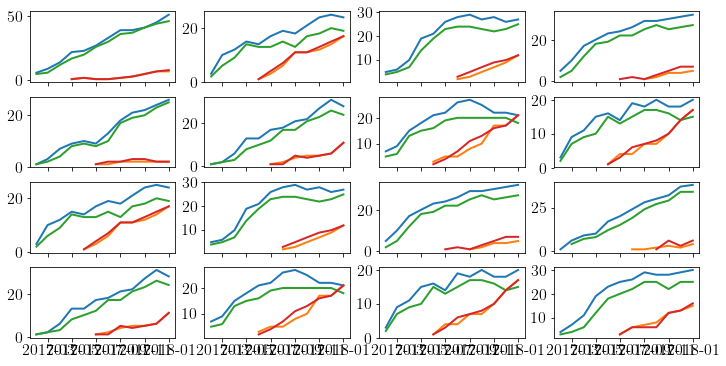

In [33]:
f, axarr = plt.subplots(4,4, sharex=True)
for a in range(4):
    for b in range(4):
        dat = complete_reports.loc[list(complete_reports.index.levels[0])[2*b + a]]
        dat.index = pd.to_datetime(dat.index)
        axarr[a,b].plot(dat) ;